Training Metrics:

Metrics by Class:

Class: no
Accuracy: 0.84
Precision: 0.81
Recall: 0.90
F1 Score: 0.85
Cohen Kappa: 0.69

Class: yes
Accuracy: 0.84
Precision: 0.88
Recall: 0.79
F1 Score: 0.84
Cohen Kappa: 0.69

Testing Metrics:

Metrics by Class:

Class: no
Accuracy: 0.80
Precision: 0.78
Recall: 0.91
F1 Score: 0.84
Cohen Kappa: 0.56

Class: yes
Accuracy: 0.80
Precision: 0.82
Recall: 0.64
F1 Score: 0.72
Cohen Kappa: 0.56

Training Accuracy: 84.40%
Validation Accuracy: 77.78%
Testing Accuracy: 79.63%


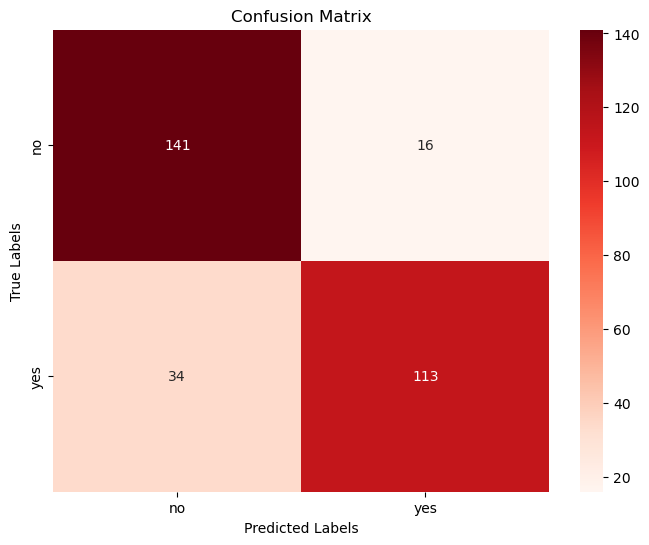

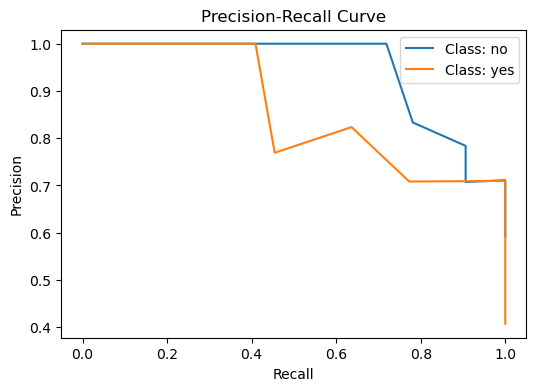

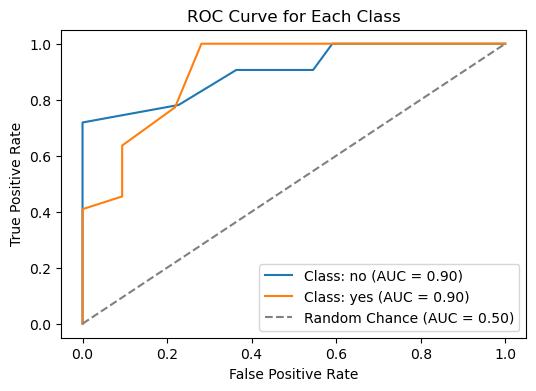

In [9]:
#KNN

import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf

# Step 1: Extract the uploaded ZIP file
data_dir = "C:\\Users\\princ\\Downloads\\dataset1"
zip_file = 'dataset1.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Step 2: Load and preprocess the data
def load_data(data_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root, file)
                label = os.path.basename(root)

                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label)

    images = np.array(images) / 255.0  # Normalize images
    labels = np.array(labels)

    return images, labels

# Load the dataset
images, labels = load_data(data_dir)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Flatten the image data for KNN (128 * 128 * 3)
images_flattened = images.reshape(images.shape[0], -1)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images_flattened, labels_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Step 4: Define the K-Nearest Neighbors (KNN) model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Step 5: Train the model
knn_model.fit(X_train, y_train)

# Step 6: Evaluate the model
train_acc = knn_model.score(X_train, y_train)
val_acc = knn_model.score(X_val, y_val)
test_acc = knn_model.score(X_test, y_test)

# Predict for training and testing sets
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

# Step 7: Metrics per class
def print_class_metrics(true_labels, pred_labels, class_names):
    print("\nMetrics by Class:")
    for i, class_name in enumerate(class_names):
        class_true = (true_labels == i).astype(int)
        class_pred = (pred_labels == i).astype(int)
        
        precision = precision_score(class_true, class_pred)
        recall = recall_score(class_true, class_pred)
        f1 = f1_score(class_true, class_pred)
        cohen_kappa = cohen_kappa_score(class_true, class_pred)
        accuracy = np.mean(class_true == class_pred)
        
        print(f"\nClass: {class_name}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"Cohen Kappa: {cohen_kappa:.2f}")

# Print metrics for training data
print("Training Metrics:")
print_class_metrics(y_train, y_train_pred, label_encoder.classes_)

# Print metrics for testing data
print("\nTesting Metrics:")
print_class_metrics(y_test, y_test_pred, label_encoder.classes_)

# Print overall results
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

# Step 8: Overall confusion matrix (combined training and testing data)
y_combined_true = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))
overall_cm = confusion_matrix(y_combined_true, y_combined_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 9: Precision-Recall Curve for each class
def plot_precision_recall(true_labels, pred_probs, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(true_labels == i, pred_probs[:, i])
        plt.plot(recall, precision, label=f'Class: {class_name}')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Get prediction probabilities for the test set (for precision-recall and ROC curves)
# KNN in `scikit-learn` provides `predict_proba()` for probability estimates
y_test_probs = knn_model.predict_proba(X_test)

# Plot Precision-Recall curves for each class
plot_precision_recall(y_test, y_test_probs, label_encoder.classes_)

# Step 10: Plot ROC Curve for each class
def plot_roc_curve(true_labels, pred_probs, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class: {class_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line for random chance
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance (AUC = 0.50)')
    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Plot ROC curves for each class
plot_roc_curve(y_test, y_test_probs, label_encoder.classes_)


Training Metrics:

Metrics by Class:

Class: no
Accuracy: 0.84
Precision: 0.81
Recall: 0.90
F1 Score: 0.85
Cohen Kappa: 0.69

Class: yes
Accuracy: 0.84
Precision: 0.88
Recall: 0.79
F1 Score: 0.84
Cohen Kappa: 0.69

Testing Metrics:

Metrics by Class:

Class: no
Accuracy: 0.80
Precision: 0.78
Recall: 0.91
F1 Score: 0.84
Cohen Kappa: 0.56

Class: yes
Accuracy: 0.80
Precision: 0.82
Recall: 0.64
F1 Score: 0.72
Cohen Kappa: 0.56

Training Accuracy: 84.40%
Validation Accuracy: 77.78%
Testing Accuracy: 79.63%


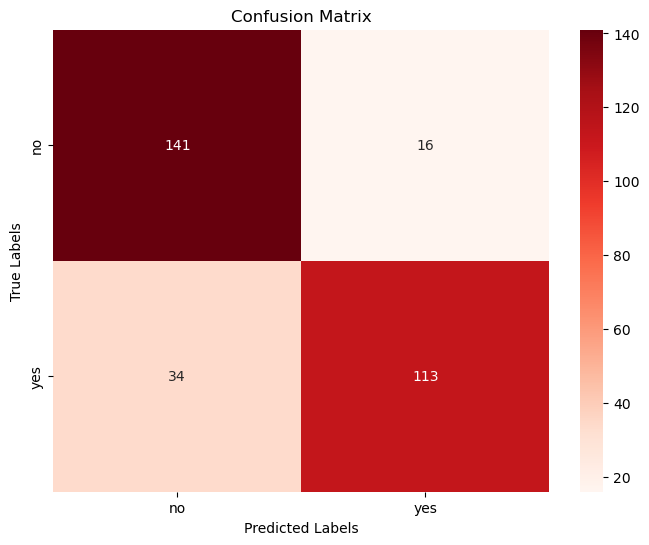

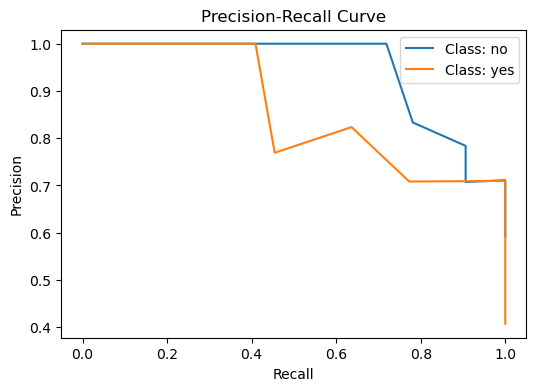

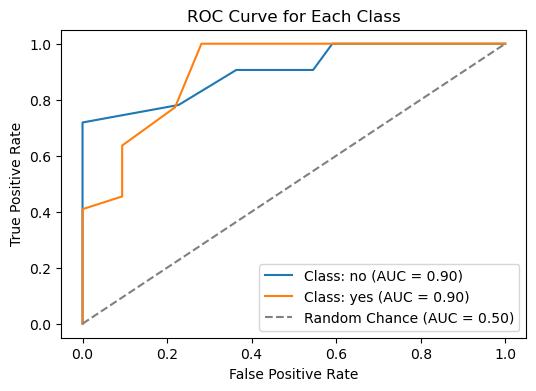

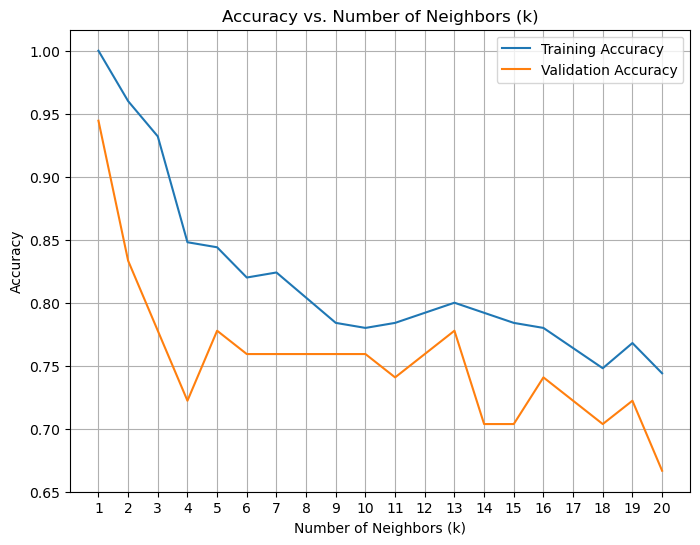

Optimal k based on validation accuracy: 1
Testing Accuracy with k=1: 98.15%


In [6]:
#KNN

import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf

# Step 1: Extract the uploaded ZIP file
data_dir = "C:\\Users\\princ\\Downloads\\dataset1"
zip_file = 'dataset1.zip'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

# Step 2: Load and preprocess the data
def load_data(data_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root, file)
                label = os.path.basename(root)

                # Load and preprocess the image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(label)

    images = np.array(images) / 255.0  # Normalize images
    labels = np.array(labels)

    return images, labels

# Load the dataset
images, labels = load_data(data_dir)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Flatten the image data for KNN (128 * 128 * 3)
images_flattened = images.reshape(images.shape[0], -1)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(images_flattened, labels_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Step 4: Define the K-Nearest Neighbors (KNN) model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Step 5: Train the model
knn_model.fit(X_train, y_train)

# Step 6: Evaluate the model
train_acc = knn_model.score(X_train, y_train)
val_acc = knn_model.score(X_val, y_val)
test_acc = knn_model.score(X_test, y_test)

# Predict for training and testing sets
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

# Step 7: Metrics per class
def print_class_metrics(true_labels, pred_labels, class_names):
    print("\nMetrics by Class:")
    for i, class_name in enumerate(class_names):
        class_true = (true_labels == i).astype(int)
        class_pred = (pred_labels == i).astype(int)
        
        precision = precision_score(class_true, class_pred)
        recall = recall_score(class_true, class_pred)
        f1 = f1_score(class_true, class_pred)
        cohen_kappa = cohen_kappa_score(class_true, class_pred)
        accuracy = np.mean(class_true == class_pred)
        
        print(f"\nClass: {class_name}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        print(f"Cohen Kappa: {cohen_kappa:.2f}")

# Print metrics for training data
print("Training Metrics:")
print_class_metrics(y_train, y_train_pred, label_encoder.classes_)

# Print metrics for testing data
print("\nTesting Metrics:")
print_class_metrics(y_test, y_test_pred, label_encoder.classes_)

# Print overall results
print(f"\nTraining Accuracy: {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Testing Accuracy: {test_acc * 100:.2f}%")

# Step 8: Overall confusion matrix (combined training and testing data)
y_combined_true = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))
overall_cm = confusion_matrix(y_combined_true, y_combined_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 9: Precision-Recall Curve for each class
def plot_precision_recall(true_labels, pred_probs, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(true_labels == i, pred_probs[:, i])
        plt.plot(recall, precision, label=f'Class: {class_name}')

    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Get prediction probabilities for the test set (for precision-recall and ROC curves)
# KNN in `scikit-learn` provides `predict_proba()` for probability estimates
y_test_probs = knn_model.predict_proba(X_test)

# Plot Precision-Recall curves for each class
plot_precision_recall(y_test, y_test_probs, label_encoder.classes_)

# Step 10: Plot ROC Curve for each class
def plot_roc_curve(true_labels, pred_probs, class_names):
    plt.figure(figsize=(6, 4))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(true_labels == i, pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class: {class_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line for random chance
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance (AUC = 0.50)')
    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Plot ROC curves for each class
plot_roc_curve(y_test, y_test_probs, label_encoder.classes_)



# Step 11: Visualize accuracy for different values of `k`
k_values = range(1, 21)  # Explore k values from 1 to 20
train_accuracies = []
val_accuracies = []

for k in k_values:
    # Train KNN model with different `k`
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    
    # Record training and validation accuracy
    train_accuracies.append(knn_model.score(X_train, y_train))
    val_accuracies.append(knn_model.score(X_val, y_val))

# Plot training and validation accuracy vs. `k`
plt.figure(figsize=(6,4))
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.show()

# Retrain the model with the best k (if needed)
optimal_k = k_values[np.argmax(val_accuracies)]
print(f"Optimal k based on validation accuracy: {optimal_k}")

# Retrain the model with the optimal k value
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)

# Recalculate testing accuracy
test_acc = knn_model.score(X_test, y_test)
print(f"Testing Accuracy with k={optimal_k}: {test_acc * 100:.2f}%")


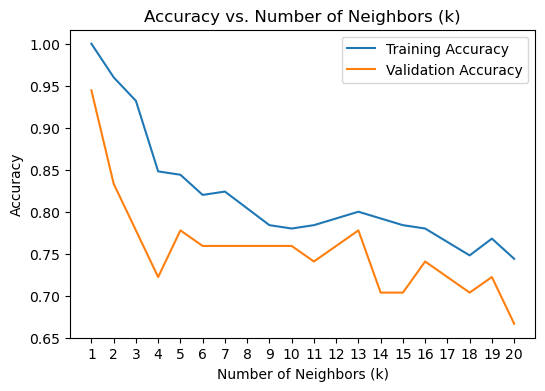

In [8]:
# Step 11: Visualize accuracy for different values of `k`
k_values = range(1, 21)  # Explore k values from 1 to 20
train_accuracies = []
val_accuracies = []

for k in k_values:
    # Train KNN model with different `k`
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    
    # Record training and validation accuracy
    train_accuracies.append(knn_model.score(X_train, y_train))
    val_accuracies.append(knn_model.score(X_val, y_val))

# Plot training and validation accuracy vs. `k`
plt.figure(figsize=(6,4))
plt.plot(k_values, train_accuracies, label='Training Accuracy')
plt.plot(k_values, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.show()